## Fetch 2009 PhysioNet challenge data

https://archive.physionet.org/challenge/2009/

In [2]:
from bs4 import BeautifulSoup
import gcsfs  ## Google Cloud Storage file system
import os
import pandas as pd
import requests
import tarfile
import wfdb

from src.data.parsing import parse_txt

source_url = 'https://archive.physionet.org/challenge/2009/training-set-clinical-data.tar.gz'
target_dir = 'data'
target_path = f'{target_dir}/training-set-clinical-data.tar.gz'


In [ ]:
%env PROJECT_ID=

In [5]:
fs = gcsfs.GCSFileSystem(project=os.environ['PROJECT_ID'])
bucket = 'physionet_2009'
fs.ls(bucket)

['physionet_2009/mimic2cdb',
 'physionet_2009/test-set-a',
 'physionet_2009/test-set-b',
 'physionet_2009/train_wave']

In [10]:
def fetch_settings():
    return {
        'fetch_clinical_data': False,
        'verbose': False,
        'google_cloud': {
            'project': os.environ['PROJECT_ID']
        }
    }

## Fetch archive of PhysioNet challenge records

In [ ]:
if fetch_settings()['fetch_clinical_data']:
    response = requests.get(source_url, stream=True)
    if response.status_code == 200:
        with open(target_path, 'wb') as f:
            f.write(response.raw.read())

    with tarfile.open(target_path, "r:gz") as tar_file:
        tar_file.extractall(target_dir)
else: 
    print("Use cached clinical data")

## Training data and labels

In [116]:
training_set = [
's21775', 's20658', 's22466','s05336', 's06349',
's08718', 's20794', 's24799', 's26318', 's14204',
's25699', 's07125', 's19208', 's12821', 's06637',
    
's02395', 's08779', 's23641', 's24924', 's00439', 
's23015', 's19603', 's02172', 's26105', 's23594',
's21817', 's24984', 's25602', 's23591', 's15687',
    
's17765', 's04860', 's26097', 's00318', 's14495',
's22888', 's26296', 's06180', 's07468', 's24004',
's03133', 's02280', 's09672', 's19418', 's15465',
    
's05786', 's25222', 's02561', 's24923', 's16019',
's04286', 's17069', 's07860', 's23020', 's24431',
's22657', 's09341', 's05126', 's10611', 's05289'
]

training_labels = [
'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1',
'H1', 'H1', 'H1', 'H1', 'H1', 'H1', 'H1',
    
'H2', 'H2', 'H2', 'H2', 'H2', 'H2', 'H2', 'H2',
'H2', 'H2', 'H2', 'H2', 'H2', 'H2', 'H2',
    
'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 
'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1',

'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2',
'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2'
]

len(training_set) == len(training_labels)

True

## Handle individual records

In [ ]:
record_map = pd.read_csv(
    fs.open(f'{bucket}/mimic2cdb/MAP', 'rb'),
    sep="\t", 
    names = ['Clinical', 'Wave', 'Sex', 'Age', 'Birthdate', 'Waveform'],
    index_col = False, 
    skiprows = [0,1])
record_map = record_map[record_map['Clinical'].isin(training_set)]

## Functions to generate waveform data set

In [110]:
def generate_record_map():
    settings = fetch_settings()
    df = pd.read_csv(
        fs.open(f'{bucket}/mimic2cdb/MAP', 'rb'),
        sep="\t", 
        names = ['Clinical', 'Wave', 'Sex', 'Age', 'Birthdate', 'Waveform'],
        index_col = False, 
        skiprows = [0,1])
    df = df[df['Clinical'].isin(training_set)]
    if settings['verbose']:
        print(f"Dimensions of data set: {df.shape}")
        print(f"Data set reflects data for {len(df['Clinical'].unique().tolist())} clinical IDs")
        print(f"Data set reflects data for {len(df['Wave'].unique().tolist())} waveform IDs")
    return({'data':df, 
            'clinical_entities': df['Clinical'].unique().tolist(),
            'waveform_entities': df['Wave'].unique().tolist()
           })


def filter_data_to_entity(df, entity_colname, entity):
    return df[df[entity_colname] == entity]


def generate_waveform_dataset(e, df):
    settings = fetch_settings()
    data = filter_data_to_entity(df, 'Wave', e)
    data = data.squeeze().to_dict()
    result = {'raw_data': data}
    
    if settings['verbose']: print(data)
    record = wfdb.rdrecord(f"data/train_wave/{data['Wave']}")
    return {
        'raw_data': data,
        'waveform_record': record.__dict__
    }
    

## Generate the data set

In [ ]:
record_map = generate_record_map()
x = {e:generate_waveform_dataset(e, record_map['data']) for e in record_map['waveform_entities'][0:5]}
x.keys()

In [ ]:
x['a40099']['waveform_record']

AxesSubplot(0.125,0.125;0.775x0.755)


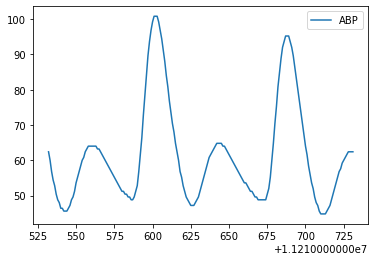

In [117]:
record = x['a40099']['waveform_record']
df = pd.DataFrame(record['p_signal'], columns = record['sig_name'])
df = df[~df['ABP'].isna()]

## Think we're isolating an arterial waveform show systolic and diastolic pressure
## as well as dicrotic notch
print(df[['ABP']].iloc[1419800:1420000].plot())